# Gaussian Process Regression 



In [2]:
!pip3 install gpytorch

     |████████████████████████████████| 503 kB 1.5 MB/s eta 0:00:01


In [5]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

### Data

-Sin함수를 Generator Function으로 하는 데이터셋을 생성한다  
-데이터셋도 Gaussian Distribution을 따르도록 생성한다

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}


In [6]:
torch.manual_seed(1111) # 랜덤시드 적용할 셀에 입력
train_x = torch.linspace(0, 1, 100)             # 0~1사이 수를 100등분
print(train_x.size())
train_x                                                          

torch.Size([100])


tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])

In [9]:
train_y = torch.sin(train_x*(2*math.pi)) + torch.randn(train_x.size())*math.sqrt(0.04)    # 가우시안 노이즈 추가
train_y.shape

torch.Size([100])

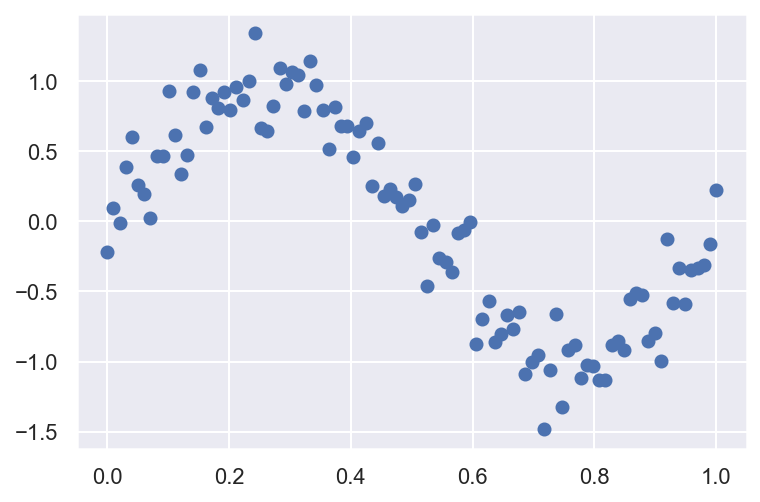

In [10]:
plt.scatter(train_x, train_y)
plt.show()  

## Model

### GP관련 함수들

1.  **GP Model** (`gpytorch.models.ExactGP`)
1.  **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`)
1.  **Mean** - `gpytorch.means.ConstantMean()` 
1.  **Kernel** - `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` 
1.  **MultivariateNormal** (`gpytorch.distributions.MultivariateNormal`)
  

In [81]:
train_x.reshape(-1,)

tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])

In [126]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [127]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)           # GP 모델 선언
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [128]:
# GP의 loss 역할(최적화 방향성의 지표) - Marginal Log Likelihood
# maximum 에 해당하도록 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

## Training


여기서의 training은 noise나 length scale같은 하이퍼파라미터를 업데이트 하는 과정. 

In [129]:
epoch = 20

model.train()
likelihood.train()

for i in range(epoch):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, epoch, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()))
    

Iter 1/20 - Loss: 0.936   lengthscale: 0.644   noise: 0.644
Iter 2/20 - Loss: 0.904   lengthscale: 0.598   noise: 0.598
Iter 3/20 - Loss: 0.870   lengthscale: 0.555   noise: 0.554
Iter 4/20 - Loss: 0.833   lengthscale: 0.514   noise: 0.513
Iter 5/20 - Loss: 0.790   lengthscale: 0.475   noise: 0.474
Iter 6/20 - Loss: 0.743   lengthscale: 0.439   noise: 0.437
Iter 7/20 - Loss: 0.693   lengthscale: 0.404   noise: 0.402
Iter 8/20 - Loss: 0.642   lengthscale: 0.372   noise: 0.369
Iter 9/20 - Loss: 0.593   lengthscale: 0.342   noise: 0.339
Iter 10/20 - Loss: 0.548   lengthscale: 0.315   noise: 0.310
Iter 11/20 - Loss: 0.508   lengthscale: 0.292   noise: 0.284
Iter 12/20 - Loss: 0.470   lengthscale: 0.272   noise: 0.259
Iter 13/20 - Loss: 0.435   lengthscale: 0.256   noise: 0.237
Iter 14/20 - Loss: 0.401   lengthscale: 0.243   noise: 0.216
Iter 15/20 - Loss: 0.368   lengthscale: 0.233   noise: 0.196
Iter 16/20 - Loss: 0.335   lengthscale: 0.225   noise: 0.179
Iter 17/20 - Loss: 0.303   length

In [135]:
for i in model.named_parameters():
    print(i)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-2.0415], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([-0.0294], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(1.1744, requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-1.4258]], requires_grad=True))


In [136]:
model.parameters()

<generator object Module.parameters at 0x7ff5952466d0>

## Prediction

In [137]:
test_x.shape

torch.Size([55])

In [138]:

model.eval()
likelihood.eval()

# TEST Mode 
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 5, 55) #외삽 확인시 Train 범위 이상의 값을 입력 
    observed_pred = likelihood(model(test_x))
    

In [139]:
observed_pred

MultivariateNormal(loc: torch.Size([55]))

## Result

In [140]:
lower

tensor([-0.7414, -0.2278,  0.1437,  0.2419,  0.0294, -0.4123, -0.9633, -1.4713,
        -1.7413, -1.6380, -1.2220, -0.8179, -0.8800, -1.3538, -1.8761, -2.2333,
        -2.4151, -2.4917, -2.5199, -2.5290, -2.5315, -2.5320, -2.5321, -2.5321,
        -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321,
        -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321,
        -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321,
        -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321, -2.5321])

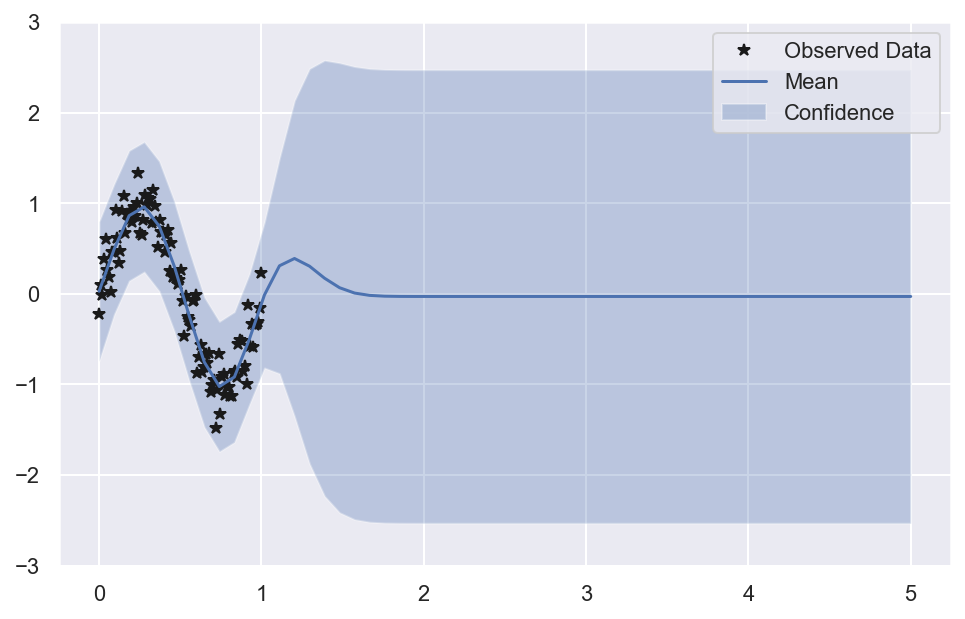

In [132]:
#Confidence boundary 확인
f, ax = plt.subplots(1, 1, figsize=(8, 5))
lower, upper = observed_pred.confidence_region()
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
ax.set_ylim([-3, 3]) # y값의 범위를 [-3, 3]

ax.legend(['Observed Data', 'Mean', 'Confidence'])


[Reference](https://github.com/cornellius-gp/gpytorch/tree/master/examples)